 # Trading VIX-related instruments based on forecasts of realised volatility of the SPY ETF
 The goal of this notebook is to see:
 - if we can trade VXX based on tomorrow's realised volatility ("RV") _(Test 1, 2)_
 - if so, can we forecast tomorrow's RV accurately enough to trade on (before txn costs) _(Test 3, 4)_

 The main papers followed to implement models used in Tests 3,4 are:
 - Corsi, Fulvio, A Simple Long Memory Model of Realized Volatility (August 18, 2004). Available at SSRN: https://ssrn.com/abstract=626064
 - Psaradellis, I. and Sermpinis, G. (2016) Modelling and trading the U.S. implied volatility indices: evidence from the VIX, VXN and VXD indices. International Journal of Forecasting, 32(4), pp. 1268-1283. Available at: http://eprints.gla.ac.uk/120240/

 The underlying rationale of these papers is that investors with different time horizons perceive volatility differently

 Therefore, we will try to forecast tomorrow's realized volatility based on 1-day, 5-day and 22-day RVs


# Common sense tests along the way:

 We want to build up to the complex models, the tests we perform below to do so are:

 1- Can we profitably trade VIX based on perfect knowledge of tomorrow's RV?

 2- Can we profitably trade VXN futures or VXX/VXZ tomorrow based on perfect knowledge of tomorrow's RV?

 3- Can we profitably trade VXN futures or VXX/VXZ ETNs tomorrow based on a simple forecast of tomorrow's RV _(Corsi model)_?

 4- Can we profitably trade VXN futures or VXX/VXZ ETNs tomorrow based on forecasts of tomorrow's RV from a complex model  _(Psaradellis model)_?

 __The above tests are evaluated with a simple trading rule: if tomorrow's forecast rv is greater _(less)_ than today, buy _(sell)_ VIX__


 The results of test 4 suggest that there is merit to performing a detailed backtest with a longer data history, better trading rules, and txn costs

In [54]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

 # Data:
 We import our intraday 5 minute data of SPY
 [Andersen et al (2000)](https:\\ssrn.com\abstract=267791) argue that 5 mins is optimal in a liquid market

In [55]:
# Import & clean intraday data
data_path = r"C:/Users/User/OneDrive/Documents/Finance/Quant/Zipline/3.Research/TimeSeries/2022.07.19 HAR-GVAR/0.Data/"

df = pd.read_csv(data_path+"SPY20220720.csv",
                 index_col = "Date",
                 parse_dates = True)
df.index.name = "date"
df.drop(["Unnamed: 0", "Ticker", "HighLow","WAP","Count"], axis = 1, inplace = True)

df.tail()

,Open,Close,Volume,High,Low
date,,,,,
2022-07-19 20:35:00,391.48,391.98,11810,392.03,391.47
2022-07-19 20:40:00,391.98,392.68,14114,392.71,391.96
2022-07-19 20:45:00,392.68,392.31,22650,392.87,392.29
2022-07-19 20:50:00,392.32,392.23,19285,392.66,392.00
2022-07-19 20:55:00,392.22,392.24,52157,392.73,392.08


In [56]:
# Download VIX & SPY volume data from yahoo finance
# First Run
# start = str(df.index[0].date())
# end = str(df.index[-1].date())
# SPY_daily = data.DataReader("SPY", start=start, end=end, data_source="yahoo")[["Volume"]]# Import only the columns we need
# VIX_daily = data.DataReader("^VIX", start=start, end=end, data_source="yahoo")[["Adj Close"]]
# SPY_daily.to_csv(data_path+"SPY_daily.csv")
# VIX_daily.to_csv(data_path+"VIX_daily.csv")

# Second Run Onwards
SPY_daily = pd.read_csv(data_path+"SPY_daily.csv",
                        index_col = 0,
                        parse_dates = True)
VIX_daily = pd.read_csv(data_path+"VIX_daily.csv",
                        index_col = 0,
                        parse_dates = True)

# Calculate RV:
 Now that we have the data, the next steps to follow:
 - Compute daily realized volatilty from intraday data.
 - Average the values over 5 & 22 periods to get rolling weekly & monthly realized volatility

 We start by computing the daily RV, based on $n$ intraday prices:
 $RV^d_t =  \sqrt {\sum_{j=0}^{n-1} r^2_{t-j\Delta}}$

 Where:
 - $r_{t-j\Delta} = \Delta \left(ln(p_{t-j}) - ln(p_{t-(j+1))}\right)$
 - $\Delta = 1d/n_{periods}$
 - $p_t$ is the price at time $t$
 - $n$ is the number of 5 minute bars in a trading day

In [57]:
# Compute number of periods\day
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=504, minmax=(42, 78), mean=77.78571428571429, variance=7.683612610053962, skewness=-12.845465660066672, kurtosis=163.00598802395214)

 We then compute $r^2_{t-j\Delta}$ for all days.

In [58]:
df.loc[df["D"] != df["D"].shift(), "Per"]  = n_periods
df.fillna(method = 'ffill', inplace = True)

df["Ret_sq"] = np.where(df["D"] == df["D"].shift(),
                    ((np.log(df["Close"])-np.log(df["Close"].shift()))) **2, np.nan)

 Perform the sqrt(sum) grouped by days:

In [59]:
rv = np.sqrt(df.groupby("D")["Ret_sq"].agg(np.sum).to_frame())
rv.columns = ["RV_daily"]

 We can compute the weekly and monthly RV with:
 - Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
 - Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

 As an aside, to annualise volatility, one would multiply by sqrt(252) 

In [60]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

In [61]:
#Add IV & Volume variables
rv["VIX"] = VIX_daily.loc[rv.index]
rv["SPY_volume"] = SPY_daily.loc[rv.index]

print(rv.head()); print(rv.describe())

            RV_daily  RV_weekly  RV_monthly        VIX  SPY_volume
D                                                                 
2020-08-17  0.002652   0.005582    0.006187  21.350000  35481000.0
2020-08-18  0.005733   0.004834    0.006222  21.510000  38733900.0
2020-08-19  0.004814   0.004840    0.006120  22.540001  68054200.0
2020-08-20  0.004274   0.004609    0.006028  22.719999  42207800.0
2020-08-21  0.004372   0.004369    0.005807  22.540001  55106600.0
         RV_daily   RV_weekly  RV_monthly         VIX    SPY_volume
count  484.000000  484.000000  484.000000  484.000000  4.840000e+02
mean     0.007796    0.007787    0.007713   22.742603  8.212116e+07
std      0.004305    0.003673    0.002999    5.113088  3.300407e+07
min      0.001725    0.002261    0.003450   15.010000  2.645790e+07
25%      0.004602    0.004892    0.005376   18.407500  5.769988e+07
50%      0.006656    0.006831    0.006942   21.920000  7.422295e+07
75%      0.010465    0.010166    0.009775   26.384999  

In [62]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value for daily RV: 0.003804833819242558
p-value for weekly RV: 0.09400745829821422
p-value for monthly RV: 0.3825712293649965


 For all timeframes, we would want the p-value to be $\le 0.01$ so we could reject the null hypothesis that the time series has a unit root.

 This is not the case for weekly, monthly but may be due to small dataset

## Plot the RV variables

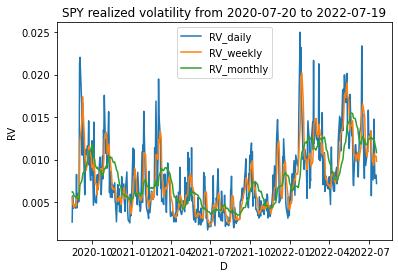

In [63]:
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"SPY realized volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()

 Prepare target
 We want to predict tomorrow's RV

In [64]:
rv["Target"] = rv["RV_daily"].shift(-1) 
rv.dropna(inplace = True)

 ### Test 1
 Test 1: can we convert perfect knowledge of RV tomorrow into a successful strategy on VIX today? (if VIX spot was tradable)

 If we can't get this right, there is no point in proceeding

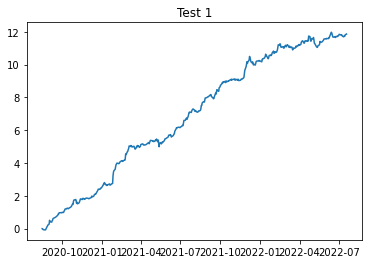

DescribeResult(nobs=483, minmax=(-0.233710235896416, 0.4802140945749818), mean=0.024566402143481585, variance=0.006121530004674745, skewness=0.6954772006239545, kurtosis=4.147639160611126)

In [65]:
test_1 = rv.copy(deep = True)
test_1.drop(["RV_daily","RV_weekly","RV_monthly","SPY_volume"], axis = 1, inplace = True)
test_1["VIX_rets"] = np.log(test_1["VIX"]/test_1["VIX"].shift(1))
test_1["weight"] = np.where(test_1["Target"] > test_1["Target"].shift(1), 1, -1)
test_1["weight"] = test_1["weight"].shift(1)
test_1["daily_rets"] = (test_1["weight"]*test_1["VIX_rets"]).fillna(0)
test_1["NAV"] = np.cumsum(test_1["daily_rets"])
plt.plot(test_1["NAV"])
plt.title("Test 1")
plt.show()
from scipy import stats
stats.describe(test_1["daily_rets"])

 ### Test 2
 Can we convert perfect knowledge of RV tomorrow into a successful strategy today on VXX which is tradable?

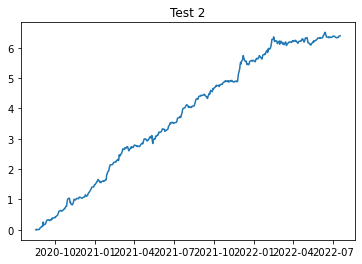

DescribeResult(nobs=483, minmax=(-0.16071558892537557, 0.24137061693989198), mean=0.013238778611900304, variance=0.0018226963246709548, skewness=0.43866643442872166, kurtosis=2.956217253583249)

In [66]:
VXX_daily = pd.read_csv(data_path+"VXX_daily.csv",
                        index_col = 0,
                        parse_dates = True)

test_2 = test_1.copy(deep = True)
test_2["VXX"] = VXX_daily
test_2["VXX_rets"] = np.log(test_2["VXX"]/test_2["VXX"].shift(1))
test_2["daily_rets"] = (test_2["weight"]*test_2["VXX_rets"]).fillna(0)
test_2["NAV"] = np.cumsum(test_2["daily_rets"])
plt.plot(test_2["NAV"])
plt.title("Test 2")
plt.show()
stats.describe(test_2["daily_rets"])

 ### Checkpoint:
 Test 1 & 2 suggest that a strat is not impossible if we get a good enough forecast

 ### Test 3:
 Can we get a trading rule on VXX using a simple model?

In [67]:
rv_scaled = rv

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop(["Target","VIX", "SPY_volume"], axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

 We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m $

 We do this with OLS:
 $\hat{\beta} = (X'X)^{-1}X'Y$

In [68]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     70.13
Date:                Sat, 13 Aug 2022   Prob (F-statistic):           5.41e-34
Time:                        22:09:25   Log-Likelihood:                 1302.3
No. Observations:                 289   AIC:                            -2597.
Df Residuals:                     285   BIC:                            -2582.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.560      0.011       0.000       0.002
RV_daily       0.4607      0.067      6.842      0.000       0.328       0.593
RV_weekly      0.2432      0.104      2.334      0.020       0.038       0.448
RV_monthly     0.0937      0.107      0.876      0.382      -0.117       0.304
==============================================================================
Omnibus:                       86.629   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.335
Skew:                           1.331   Prob(JB):                     2.18e-56
Kurtosis:                       6.768   Cond. No.                         859.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 For $\hat{\beta_3}$ (***RV_monthly***), we do not reject the null hypothesis.  Thus, this variable is not statistically significant when making a next day forecast.

 In theory we should remove, but we won't because we're following a paper

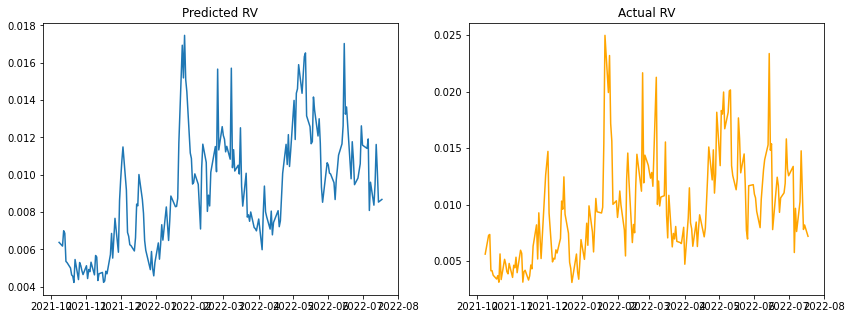

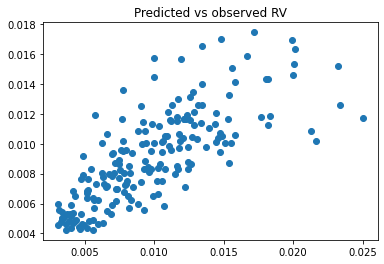

In [69]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

# #Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [70]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [71]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:7.134921097856731e-06, R^2:0.4246863692481704, MAE:0.001975640762025801
----------------
Out-of-sample scores
MSE:9.286205483637039e-06, R^2:0.5548443860908494, MAE:0.002202934429431818


 The explanatory variables explain $55.5\%$ of the variance of the dependent variable out-of-sample.

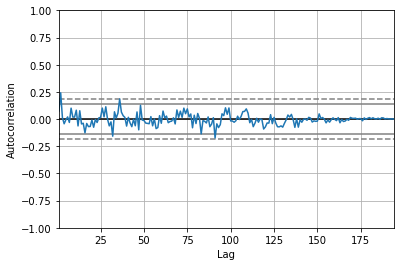

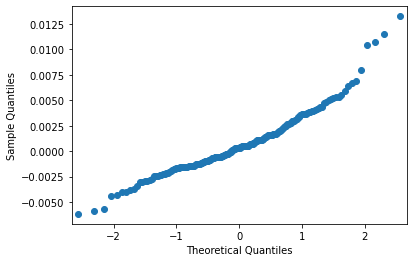

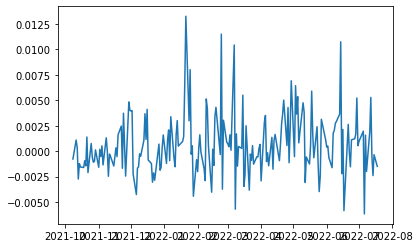

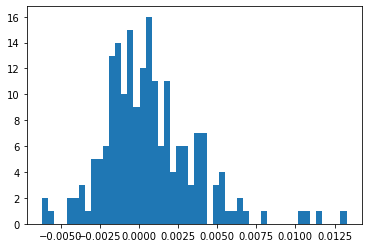

In [72]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()

 Slight positive skew in the residuals

 ### Test 3
 Can we convert a simple forecast into a trading strategy?

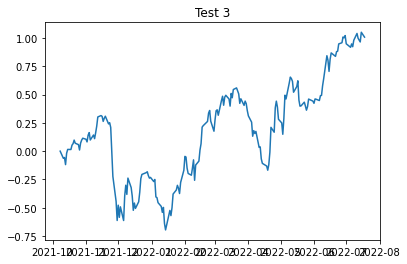

Hit rate: 0.520618556701031


In [73]:
test_3 = rv.copy(deep = True)
test_3.drop(["RV_weekly","RV_monthly","SPY_volume"], axis = 1, inplace = True)
test_3["forecast"] = y_hat
test_3 = test_3.loc[y_hat.index]
test_3["VIX_rets"] = np.log(test_3["VIX"]/test_3["VIX"].shift(1))

test_3["weight"] = np.where(test_3["forecast"] > test_3["forecast"].shift(1), 1, -1)
test_3["weight"] = test_3["weight"].shift(1)
test_3["daily_rets"] = (test_3["weight"]*test_3["VIX_rets"]).fillna(0)
test_3["NAV"] = np.cumsum(test_3["daily_rets"])
plt.plot(test_3["NAV"])
plt.title("Test 3")
plt.show()
stats.describe(test_3["daily_rets"])
hit_rate = np.sum(test_3["daily_rets"] >0)/len(test_3)
print("Hit rate: "+str(hit_rate))

 The results are not good enough to trade, but are good enough to encourage further testing

 ## GASVR
 Next we'll use a GA to optimise parameters for a nuSVR model which uses the same inputs & target
 
 Psaradellis splits their data into train/test sets and sets the fitness function to minimise MSE on the test set
 
 We'll use R_squared on cross validated predictions instead because we don't have a lot of data
 We floor our R_squared at 0.00001, because the roulette selection needs all fitness values > 0

In [74]:
import random
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn import svm

In [75]:
# settings
number_of_population = 100
number_of_generation = 200
svr_c_2_range = (0.000001, 10)
svr_nu_2_range = (0.1, 1)
fold_number = 5 # used in cross validation
probability_of_crossover = 0.9
probability_of_mutation = 0.1
threshold_of_variable_selection = 0.5

In [76]:
# autoscaling not done, because it would add forward-looking bias
autoscaled_X_train = X_train.drop("const", axis = 1).copy(deep = True) 
autoscaled_X_train = autoscaled_X_train.values

autoscaled_y_train = y_train
autoscaled_y_train = np.concatenate(autoscaled_y_train.values)

## GASVR
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

min_boundary = np.zeros(autoscaled_X_train.shape[1] + 2)
max_boundary = np.ones(autoscaled_X_train.shape[1] + 2) * 1.0
min_boundary[-2] = svr_c_2_range[0]
min_boundary[-1] = svr_nu_2_range[0]
max_boundary[-2] = svr_c_2_range[1]
max_boundary[-1] = svr_nu_2_range[1]

c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [77]:
def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index

toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    # individual_array = np.array(pop[0])
    individual_array = np.array(individual)
    # Choose a random mix of variables
    selected_X_variable_numbers = np.where(individual_array[:-2] >=
                                           threshold_of_variable_selection)[0]
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    if len(selected_X_variable_numbers) and (individual_array[-2] > 0) and (individual_array[-1] > 0):
        # cross-validation
        model_in_cv = svm.NuSVR(kernel='rbf', C= individual_array[-2],
                              nu= individual_array[-1])
        # try: #Fix the fact that nu,C =0 are being passed
        estimated_y_train_in_cv = model_selection.cross_val_predict(model_in_cv, 
                                                                    selected_autoscaled_X_train,
                                                                    autoscaled_y_train, 
                                                                    cv=fold_number)
        # value = 1/score(estimated_y_train_in_cv,autoscaled_y_train, "MSE")
        value = max(0.0000001,
                    1 - sum((autoscaled_y_train - estimated_y_train_in_cv) ** 2) / sum((autoscaled_y_train - np.average(autoscaled_y_train)) ** 2))
        #Will be less than zero if sumsq residuals exceeds sum sq
    else:
        # print('error evaluating:',individual)
        value = 0.0000001

    return value,

toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selRoulette)

In [78]:
random.seed(100)
pop = toolbox.population(n=number_of_population)
best_fit = []
best_fit_score = []
print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    #This will create an offspring list, which is an exact copy of the selected individuals. 
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5


    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)
    best_fit.append(pop[np.argmax(fits)])
    best_fit_score.append(max(fits))
    # TODO: fix convergence 
    # if np.abs(max(fits) - mean) < 0.005:
    #     print("Converged")
    #     break

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array[:-2] >= threshold_of_variable_selection)[0]
C_final = best_individual[-2]
nu_final = best_individual[-1]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

Start of evolution
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 95 individuals
  Min 1e-07
  Max 0.3630913699246767
  Avg 0.23497311157814216
  Std 0.126045053262666
-- Generation 2 --
  Evaluated 82 individuals
  Min 1e-07
  Max 0.3630913699246767
  Avg 0.2788491778044955
  Std 0.10107717757024147
-- Generation 3 --
  Evaluated 97 individuals
  Min 1e-07
  Max 0.37150468416157045
  Avg 0.299200019298442
  Std 0.09509863431784162
-- Generation 4 --
  Evaluated 85 individuals
  Min 0.12554865740715526
  Max 0.37150468416157045
  Avg 0.32344280947629506
  Std 0.042743690092265425
-- Generation 5 --
  Evaluated 89 individuals
  Min 1e-07
  Max 0.37150468416157045
  Avg 0.306527103737547
  Std 0.08696515862698943
-- Generation 6 --
  Evaluated 82 individuals
  Min 1e-07
  Max 0.37150468416157045
  Avg 0.3247362860326563
  Std 0.055620293065692605
-- Generation 7 --
  Evaluated 98 individuals
  Min 1e-07
  Max 0.3704897823177081
  Avg 0.32838298532195265
  Std 0.06294574215602

 ## Fitting the optimised nuSVR model

 #### Insample

In [79]:
final_SVR = svm.NuSVR(kernel='rbf', C= C_final,
                        nu= nu_final)
selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]

reg = final_SVR.fit(selected_autoscaled_X_train, autoscaled_y_train)
y_temp = reg.predict(selected_autoscaled_X_train)
estimated_y_train_final = y_temp
value = reg.score(selected_autoscaled_X_train, autoscaled_y_train)
print("IS R2: "+str(value))

IS R2: 0.4135851673840857


 #### Outsample

In [80]:
autoscaled_X_test = X_test.drop(["const"], axis = 1).values
autoscaled_y_test = np.concatenate(y_test.values)

selected_autoscaled_X_test = autoscaled_X_test[:, selected_X_variable_numbers]

y_temp = reg.predict(selected_autoscaled_X_test)
estimated_y_train_final = pd.Series(y_temp, index = y_test.index)
value = reg.score(selected_autoscaled_X_test, autoscaled_y_test)
print("OOS R2: "+str(value))

OOS R2: 0.318607632211411


 ## Test 3 & 4: can we beef up the returns with the nuSVR model?

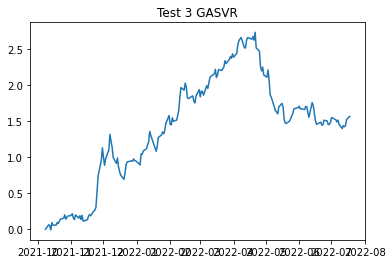

Hit rate: 0.5412371134020618


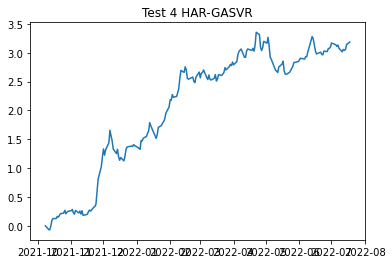

Hit rate: 0.5876288659793815


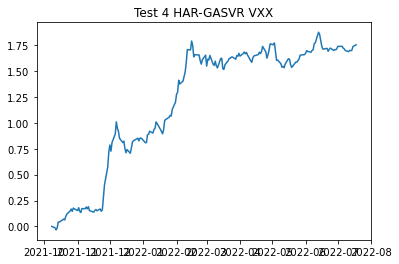

Hit rate: 0.5876288659793815


In [81]:
test_3["forecast_GASVR"] = estimated_y_train_final
test_3["weight_GASVR"] = np.where(test_3["forecast_GASVR"] > test_3["forecast_GASVR"].shift(1), 1, -1)
test_3["daily_rets_GASVR"] = (test_3["weight_GASVR"]*test_3["VIX_rets"]).fillna(0)
test_3["NAV_GASVR"] = np.cumsum(test_3["daily_rets_GASVR"])

plt.plot(test_3["NAV_GASVR"])
plt.title("Test 3 GASVR")
plt.show()
stats.describe(test_3["daily_rets_GASVR"])
hit_rate = np.sum(test_3["daily_rets_GASVR"] >0)/len(test_3)
print("Hit rate: "+str(hit_rate))

test_4 = test_3.copy(deep = True)
test_4["forecast_HAR_GASVR"] = test_4["forecast_GASVR"]+test_3["forecast"]
test_4["weight_HAR_GASVR"] = np.where(test_4["forecast_HAR_GASVR"] > test_4["forecast_HAR_GASVR"].shift(1), 1, -1)
test_4["daily_rets_HAR_GASVR"] = (test_4["weight_HAR_GASVR"]*test_4["VIX_rets"]).fillna(0)
test_4["NAV_HAR_GASVR"] = np.cumsum(test_4["daily_rets_HAR_GASVR"])

plt.plot(test_4["NAV_HAR_GASVR"])
plt.title("Test 4 HAR-GASVR")
plt.show()
stats.describe(test_4["daily_rets_HAR_GASVR"])
hit_rate = np.sum(test_4["daily_rets_HAR_GASVR"] >0)/len(test_4)
print("Hit rate: "+str(hit_rate))


test_4["VXX"] = VXX_daily
test_4["VXX_rets"] = np.log(test_4["VXX"]/test_4["VXX"].shift(1))
test_4["daily_rets_HAR_GASVR_VXX"] = (test_4["weight_HAR_GASVR"]*test_4["VXX_rets"]).fillna(0)
test_4["NAV_HAR_GASVR_VXX"] = np.cumsum(test_4["daily_rets_HAR_GASVR_VXX"])

plt.plot(test_4["NAV_HAR_GASVR_VXX"])
plt.title("Test 4 HAR-GASVR VXX")
plt.show()
stats.describe(test_4["daily_rets_HAR_GASVR_VXX"])
hit_rate = np.sum(test_4["daily_rets_HAR_GASVR"] >0)/len(test_4)
print("Hit rate: "+str(hit_rate))

# Summary
 This code looked at buying and selling VXX ETF based on a forecast of tomorrow's RV
 The final model chooses long/short on VXX based on a HAR-GASVR forecast of tomorrow's RV
 The results are not achievable in practice due to txn costs, but there may be ways to juice up returns e.g. only trade when difference between forecast and current exceeds a threshold
 Next steps are:
 - Use GASVR to predict residuals from HAR model instead of predicting rv
 - Add closing price of VIX and the daily traded volume in SPY as factors
 - better trading rules e.g. only trade if forecast tomorrow exceeds current by threshold (check if more extreme thresholds improve trade statistics)
 - Zipline backtest which includes commissions, smarter trading rules, longer history
 - Intraday backtest
# Future Research:
 In reality, there are added costs to putting our trade on:

 - VXN futures: future premium to spot + txn costs (comm + B/O spread)

 - VXX/VXZ ETN: future premium to spot on underlying futures, tracking error, fees on ETN, txn costs (comm + B/O spread)

 - Overfitting costs

 - Slight lookahead bias when using today's RV as an independent variable as this be known with certainty after the close

 Since the initial modelling shows promise, a full backtest will be performed to optimise trading rules, use a longer history, etc.